## House Prices: Advanced Regression Techniques

Ask a home buyer to describe their dream house, 

and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. 

But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. 

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home. Submissions are evaluated on Root-Mean-Squared-Error (RMSE).

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [42]:
train_url = "https://storage.googleapis.com/py_ml_datasets/house_prices/train.csv"
test_url = "https://storage.googleapis.com/py_ml_datasets/house_prices/test.csv"
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

## 資料外觀

In [43]:
print("train.shape = ", train.shape)
print("test.shape  = ", test.shape)

train.shape =  (1460, 81)
test.shape  =  (1459, 80)


In [44]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [45]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [46]:
all_data = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition'], test.loc[:, 'MSSubClass':'SaleCondition']], axis = 0)
all_data.shape

(2919, 79)

## 資料外觀（2）

79 個變數中有 25 個整數型別、11 個浮點數型別與 43 個文字型別

In [47]:
import numpy as np

np.unique(all_data.dtypes.values, return_counts = True)

(array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object),
 array([25, 11, 43]))

## 查看空值

In [48]:
all_data.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [49]:
total_missing = all_data.isnull().sum().sort_values(ascending=False)

missing_percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, missing_percent], axis = 1, keys = ['Total Missing', 'Missing Percent'])
# missing_data.head(20) , join_axes= True
missing_data

# ?pd.concat

,Total Missing,Missing Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


## 特徵工程

- 刪除遺失比例過高的變數（Top 5）
- Log Transform（* 重要的特徵工程）
- 轉換類別型變數為數值（One-hot encoding）
- 將遺失值以中位數填補

In [50]:
all_data = all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
#  1. 原本不做log transform的話 : 
#  train["SalePrice"] #  0       208500 , 1       181500 , 2       223500 , 3       140000 , 4       250000 , 5       143000
#  2. 做log transform
train["SalePrice"] = np.log1p(train["SalePrice"])
#  train["SalePrice"] #  0       12.247699 , 1       12.109016 , 2       12.317171 , 3       11.849405 , 4       12.429220 , 5       11.870607

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.median())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [51]:
all_data.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageYrBlt              0
GarageCars               0
GarageArea               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
                        ..
GarageCond_TA            0
PavedDrive_N             0
PavedDrive_P             0
PavedDrive_Y             0
PoolQC_Ex                0
PoolQC_Fa                0
P

In [52]:
# 整理模型的輸入
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

## 模型

- Linear Regression
- Ridge
- Lasso
- ElasticNet

In [47]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

Linear Regression: 0.170670
Ridge: 0.128644
Lasso: 0.267405
Elastic Net: 0.263622


## 模型（2）
在 Ridge 中尋找合適的 alpha

In [48]:
# get_rmse_with_alpha
def get_rmse_with_alpha(alpha):
    ridge = Ridge(alpha = alpha)
    mse = cross_val_score(ridge, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

# 納入 alpha 參數
ridge_alphas = np.arange(1, 50, step = 1)
ridge_rmse_cv = []
for i in range(len(ridge_alphas)):
    ridge_rmse_cv.append(get_rmse_with_alpha(ridge_alphas[i]))

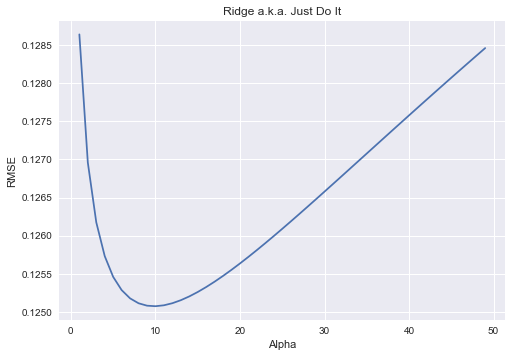

In [49]:
sns.set_style("darkgrid")
plt.plot(ridge_alphas, ridge_rmse_cv)
plt.title("Ridge a.k.a. Just Do It")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [50]:
min_rmse_cv = np.min(ridge_rmse_cv)
bool_arr = np.array(ridge_rmse_cv) == min_rmse_cv
ridge_alphas[bool_arr]

array([10])

## 上傳